In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Load data

In [2]:
california_img=mpimg.imread('data/california.png')
ca_zip_by_latlong = pd.read_csv("data/ca_zip_by_latlong.csv", delimiter=';')
ca_zip_by_latlong = ca_zip_by_latlong.set_index('Zip')
ca_pop_by_zip = pd.read_csv("data/ca_pop_by_zip.csv")
ca_pop_by_zip.rename(columns = {'zip':'Zip'}, inplace = True)
ca_pop_by_zip = ca_pop_by_zip.set_index('Zip')
print("Done")

Done


## Join data and remove null values

In [3]:
joined_data = ca_pop_by_zip.join(ca_zip_by_latlong)
joined_data.head()[['pop', 'Latitude', 'Longitude']]

,pop,Latitude,Longitude
Zip,,,
90011,109414,34.007063,-118.25868
90650,105886,33.906914,-118.08339
91331,105799,34.254751,-118.42406
90201,102433,33.972814,-118.17385
92335,99284,34.088911,-117.45213


I don't have every zip in the latlong dataset. I drop the ones I don't have.

In [4]:
joined_data[joined_data['Latitude'].isnull() | joined_data['Longitude'].isnull() | joined_data['pop'].isnull()]

,city,county,pop,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
Zip,,,,,,,,,,
95391,Tracy,San Joaquin,16562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92637,Laguna Hills,Orange,16228,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
joined_data = joined_data.drop(index=95391)
joined_data = joined_data.drop(index=92637)
assert 0 == len(joined_data[joined_data['Latitude'].isnull() | joined_data['Longitude'].isnull() | joined_data['pop'].isnull()])

## Plot population

For convenience, I pretend the map is "flat" by latitude and longitude. The projection has a bit of distortion: farther north, it's actually thinner than the image looks.

In [6]:
def plot(j, img = ""):
    # tutorial from http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/
    j.plot(kind="scatter", x="Longitude", y="Latitude",
           s=j['pop']/1000, label="population",
           alpha=0.3, figsize=(10.75, 9.6),
    )
    if str(img):
        plt.imshow(img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.3)

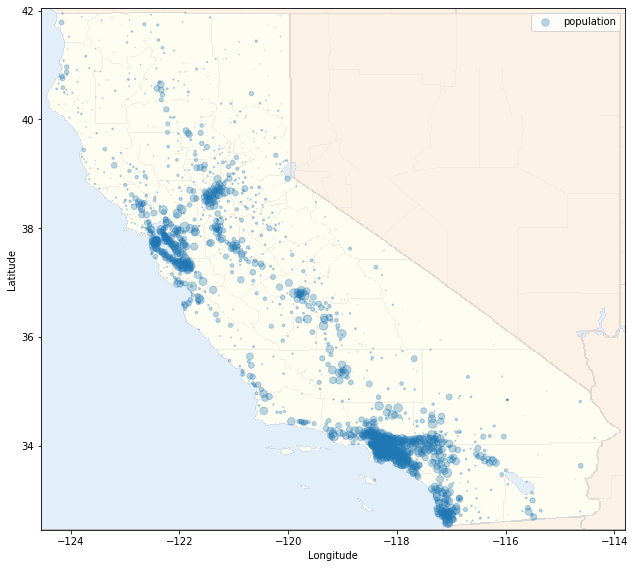

In [7]:
plot(joined_data, california_img)
plt.legend()
plt.show()

## Find population center of mass


I average the latitudes and longitudes to get the population "center of mass".

Other projections would put the population "center of mass" somewhere slightly different.

In [8]:
total_pop = sum(joined_data['pop'])
lat_avg = sum(joined_data['Latitude']*joined_data['pop']) / total_pop
long_avg = sum(joined_data['Longitude']*joined_data['pop']) / total_pop
print("Total population:", total_pop)
print("Average latlong:", lat_avg, long_avg)

Total population: 38624958
Average latlong: 35.46380319889234 -119.37869052713621


Let's find the closest ZIP code:

In [9]:
nearby_zip = ((joined_data['Longitude'] - long_avg)**2 + (joined_data['Latitude'] - lat_avg)**2).sort_values().keys()[0]
joined_data.loc[nearby_zip]

city                                 Buttonwillow
county                                       Kern
pop                                          1970
City                                 Buttonwillow
State                                          CA
Latitude                                  35.3783
Longitude                                -119.417
Timezone                                       -8
Daylight savings time flag                      1
geopoint                      35.37825,-119.41664
Name: 93206, dtype: object

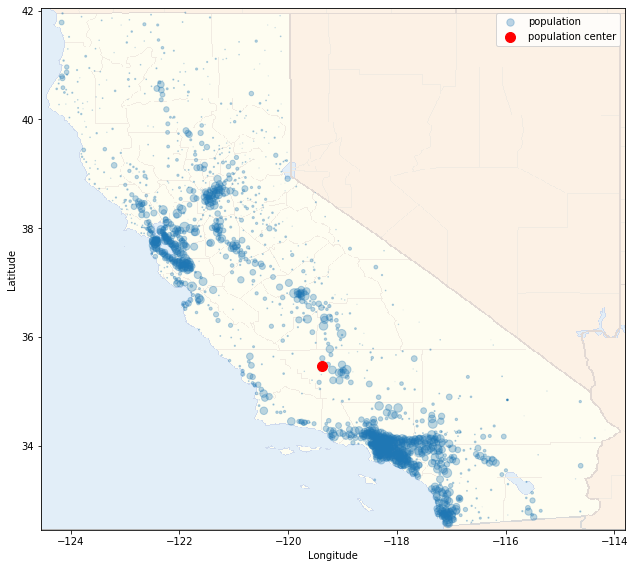

In [10]:
plot(joined_data, california_img)
plt.scatter(long_avg, lat_avg, s=100, c='red',label='population center')
plt.legend()
plt.show()

## Compare with geographic center of mass

In [11]:
# https://en.wikipedia.org/wiki/List_of_geographic_centers_of_the_United_States
geo_center = (37.166111, -119.449444)

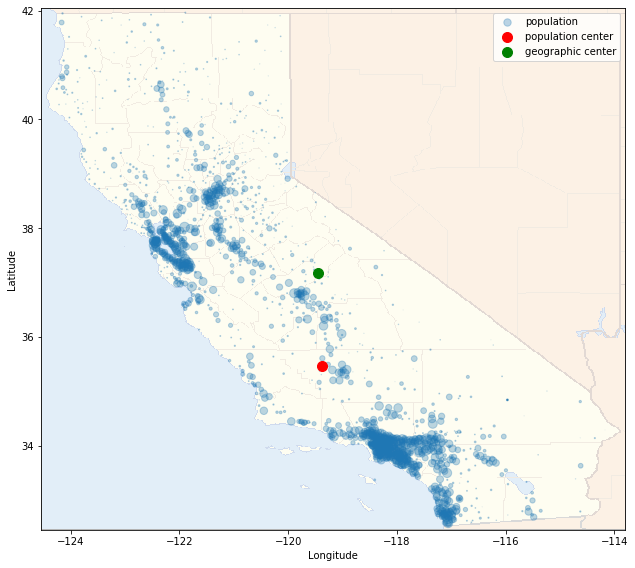

In [12]:
plot(joined_data, california_img)
plt.scatter(long_avg, lat_avg, s=100, c='red', label='population center')
plt.scatter(geo_center[1], geo_center[0], s=100, c='green', label='geographic center')
plt.legend()
plt.savefig('ca_center.png')

The geographic center is much farther north!

## Population distribution by latitude

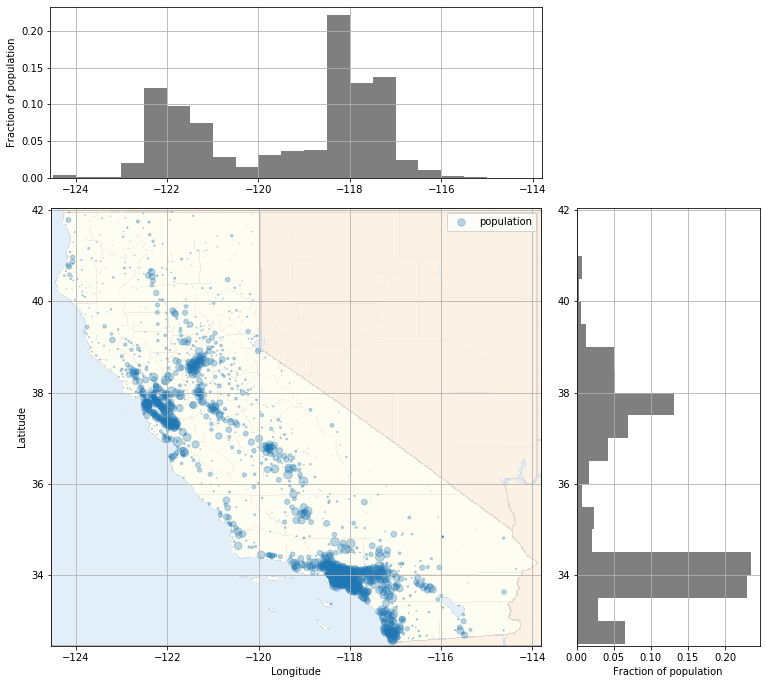

In [13]:
binwidth = 0.5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3.75, 9.6], 'width_ratios': [10.75, 4]}, tight_layout=True)

joined_data.plot(kind="scatter", x="Longitude", y="Latitude",
       s=joined_data['pop']/1000, label="population",
       alpha=0.3, ax=ax3, figsize=(10.75, 9.6)
)
ax3.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.3)
ax3.grid()

ax1.hist(joined_data['Longitude'], weights=joined_data['pop']/total_pop, bins=np.arange(-124.5, -114 + binwidth, binwidth), color='black', alpha=0.5)
ax1.set_ylabel("Fraction of population")
ax1.set_xlim(-124.55, -113.80)
ax1.grid()

ax4.hist(joined_data['Latitude'], weights=joined_data['pop']/total_pop, bins=np.arange(32.5, 42 + binwidth, binwidth), orientation="horizontal", color='black', alpha=0.5)
ax4.set_xlabel("Fraction of population")
ax4.set_ylim(32.45, 42.05)
ax4.grid()

fig.tight_layout()
ax2.set_axis_off()
plt.savefig('ca_pop_dist.png')

Some findings:
* Nearly half of all people in the state live in the LA area!
* Less than half the state lives at SLO or above.
* The Bay Area holds about 20% of the state's population.
* Less than 5% of the population lives above Sacramento.

*Thanks for reading!*